<a href="https://colab.research.google.com/github/manojmukkamala/VolcanoesOnVenus/blob/master/VenusDataCleansing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set-Up

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline

### Importing the Dataset

In [0]:
train_images = pd.read_csv("/content/drive/My Drive/VolcanoesOnVenus/Volcanoes_train/train_images.csv", header = None)

In [0]:
train_labels = pd.read_csv("/content/drive/My Drive/VolcanoesOnVenus/Volcanoes_train/train_labels.csv")

In [0]:
test_images = pd.read_csv("/content/drive/My Drive/VolcanoesOnVenus/Volcanoes_test/test_images.csv", header = None)

In [0]:
test_labels = pd.read_csv("/content/drive/My Drive/VolcanoesOnVenus/Volcanoes_test/test_labels.csv")

I implemented a basic hand written logistic regression model using the raw input data, with no hyperparameter optimizations and obtained 

- train accuracy: 85.74285714285715 %

- test accuracy: 84.12582297000732 %

The accuracy is fairly low and there is a lot of scope for improvement. Let us begin with Data Cleansing.

### Data Exploration

In [8]:
print("Training Data:", train_images.shape)
print("Testing Data:", test_images.shape)

Training Data: (7000, 12100)
Testing Data: (2734, 12100)


In [9]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12060,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,...,101,95,105,103,74,88,106,111,90,96,101,90,97,102,97,106,108,107,93,74,106,115,107,102,91,103,111,105,116,117,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,95,91,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,86,80,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,101,114,104,103,81,94,108,96,79,113,113,114,112,107,110,112,98,76,84,97,99,95,68,97,91,97,96,83,100,106,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,105,116,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115


In [10]:
train_labels.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


In [11]:
train_labels["Volcano?"].value_counts()

0    6000
1    1000
Name: Volcano?, dtype: int64

In [0]:
# df1 = train_images.join(train_labels["Volcano?"])
# df1["trn_tst"] = "train"

# df2 = test_images.join(test_labels["Volcano?"])
# df2["trn_tst"] = "test"

# df = pd.concat([df1, df2], ignore_index = True)
# del(df1, df2)

# We are not touching the test data. Lets clean amd analyze train data

df = train_images.join(train_labels["Volcano?"])

In [14]:
df = df.rename(columns = {'Volcano?':'Volcano'})
df.shape

(7000, 12101)

In [15]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano
0,95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,...,95,105,103,74,88,106,111,90,96,101,90,97,102,97,106,108,107,93,74,106,115,107,102,91,103,111,105,116,117,111,107,92,89,103,99,117,116,118,96,1
1,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,91,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81,0
2,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,80,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,114,104,103,81,94,108,96,79,113,113,114,112,107,110,112,98,76,84,97,99,95,68,97,91,97,96,83,100,106,94,81,89,84,80,90,92,80,88,96,0
4,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,116,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115,0


In [16]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano
6995,90,96,88,95,94,100,95,80,80,71,86,83,94,79,97,95,90,80,100,114,120,104,111,112,95,91,95,95,92,99,108,96,88,92,103,99,89,101,97,86,...,95,84,90,91,79,79,89,90,90,95,82,68,79,89,87,94,90,92,86,93,80,53,66,77,94,86,74,87,89,88,83,72,76,73,79,76,79,84,69,0
6996,82,82,84,91,74,61,73,80,75,97,116,108,119,104,96,84,97,93,80,86,82,66,84,78,90,81,69,88,89,91,105,105,96,69,78,91,90,66,72,70,...,91,65,62,74,86,78,78,89,76,68,91,89,79,88,98,111,115,101,75,70,61,66,70,73,103,122,112,82,91,100,78,90,88,80,88,90,90,66,71,0
6997,133,102,121,133,129,131,98,121,123,125,119,110,125,137,123,97,122,135,140,139,132,114,121,123,127,136,133,133,142,133,117,132,110,82,99,113,116,112,119,109,...,111,130,136,113,115,106,110,129,136,131,133,143,118,130,134,139,134,119,123,136,145,136,132,126,127,123,109,123,125,120,123,119,111,104,102,119,130,131,111,0
6998,118,117,115,107,92,76,100,102,81,106,117,120,115,102,96,84,81,86,81,83,84,94,103,96,96,97,87,76,83,78,87,95,74,81,97,100,77,92,99,105,...,101,93,90,103,98,109,106,99,102,101,103,96,102,98,91,107,116,112,115,104,96,92,104,111,108,110,108,84,75,104,105,102,111,99,90,105,100,100,109,0
6999,74,89,92,87,72,102,100,92,86,107,122,109,90,93,78,82,90,89,100,86,111,112,97,90,83,80,84,67,95,115,106,98,115,115,112,99,83,69,63,77,...,120,114,125,120,91,107,109,73,118,115,115,103,91,96,114,116,133,142,121,91,94,78,72,82,77,81,107,93,99,91,89,88,108,121,109,121,126,116,106,0


#### Corrupted Data

The data that we are dealing with is image data. So, there would be a good chance for data corruption.

It seems (also mentioned in data dictionary) that few records are corrupted. Take a look at the fourth record (index = 3) in the above sample dataframe. The record seems corrupted because it is having a bunch of 0's for the pixel values. 

Let's plot and see a few records and then we will build a work around to find and filter the corrupted records.

In [0]:
dfs = df.drop(columns = ["Volcano"])

In [19]:
dfs.shape

(7000, 12100)

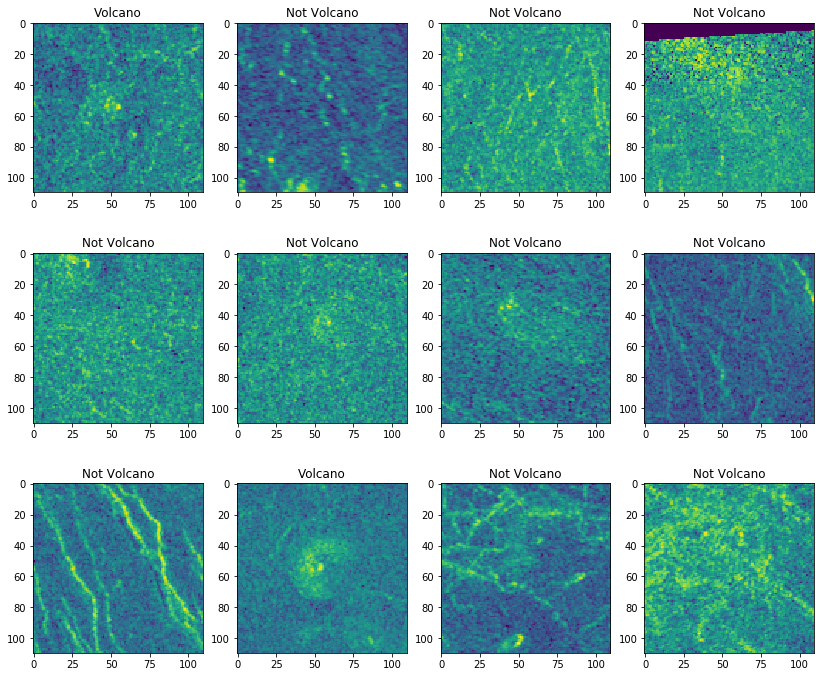

In [20]:
plt.figure(figsize = (14, 12))

for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.imshow(np.array(dfs.iloc[i]).reshape(110, 110))
    plt.title("Volcano" if df.iloc[i]["Volcano"] == 1 else "Not Volcano")

Observations:

- The fourth record has some data corrupted at the top of the image.

Let's look at the pixel value distributions for these images.

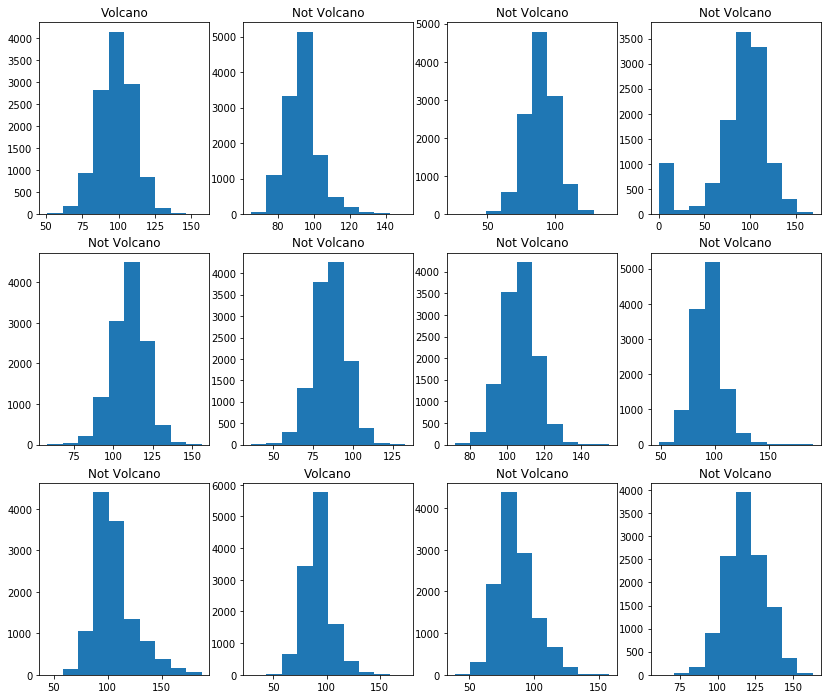

In [21]:
plt.figure(figsize = (14, 12))
for i in range(0, 12):
    subplot(3, 4, i+1)
    plt.hist(np.array(dfs.iloc[i]))
    plt.title("Volcano" if df.iloc[i]["Volcano"] == 1 else "Not Volcano")

Observations:

- According to the histogram, for the corrupted image, the number of pixels whose value is 0 is relatively high.

Let's calculate the number of dark pixels (pixel value = 0) per image. Then we will define a threshold to find and filter corrupted records.

In [0]:
df["DarkPxls"] = sum((dfs == 0), axis = 1)

Let's fetch the index of corrupted images. It is useful later.

In [0]:
crpt_id = df[df["DarkPxls"] != 0].index

#### Statistics and Distribution of Corrupted Pixels

##### Stats

In [26]:
for i, j in zip(df["DarkPxls"].loc[crpt_id].describe().index.values, df["DarkPxls"].loc[crpt_id].describe().values):
    print(str(i).upper() + " of Blank/Corrupted Pixels " + str(round(j)), "\n")

COUNT of Blank/Corrupted Pixels 271.0 

MEAN of Blank/Corrupted Pixels 8190.0 

STD of Blank/Corrupted Pixels 4500.0 

MIN of Blank/Corrupted Pixels 1.0 

25% of Blank/Corrupted Pixels 4020.0 

50% of Blank/Corrupted Pixels 11198.0 

75% of Blank/Corrupted Pixels 12100.0 

MAX of Blank/Corrupted Pixels 12100.0 



##### Quartile Plot

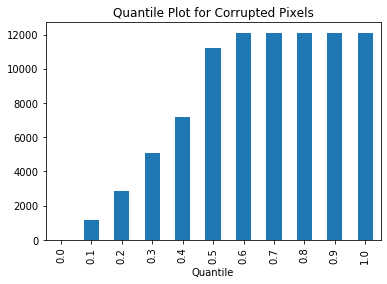

In [27]:
df["DarkPxls"].loc[crpt_id].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).plot.bar()

plt.xlabel("Quantile")
plt.title("Quantile Plot for Corrupted Pixels")
plt.show()

Observations: 

- Almost 50% of the corrupted images have all the pixels corrupted.

- 25% of the corrupted images have around 4000 pixels corrupted.

- 10% of the corrupted images have around 2000 pixels corrupted.

##### Corrupted Pixels Distribution 

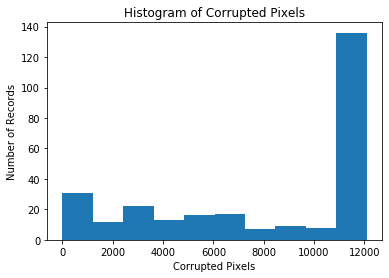

In [29]:
df["DarkPxls"].loc[crpt_id].plot.hist()

plt.title("Histogram of Corrupted Pixels")
plt.xlabel("Corrupted Pixels")
plt.ylabel("Number of Records")
plt.show()

According to the histogram, most of the corrupted images have lot of corrupted pixels.

#### Target Classes in Corrupted Images

In [33]:
df.loc[crpt_id]["Volcano"].value_counts()

0    253
1     18
Name: Volcano, dtype: int64

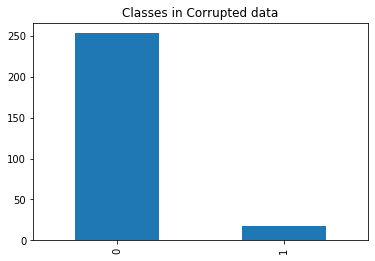

In [30]:
df.loc[crpt_id]["Volcano"].value_counts().plot.bar()

plt.title("Classes in Corrupted data")
plt.show()

Observations:

- Lot of corrupted images do not have volcanoes in them.
- Only a few corrupted records do have volcanoes.

#### Corrupted Images with Volcanoes

In [31]:
vol_crpt_id = df.loc[crpt_id][df.loc[crpt_id]["Volcano"] == 1].index.values

df.loc[vol_crpt_id].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano,DarkPxls
244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74,105,...,88,100,103,108,107,97,90,81,107,114,96,79,83,87,75,91,98,101,90,89,104,81,92,83,93,104,105,103,99,91,92,101,96,101,91,82,94,97,1,4343
613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,58,60,67,...,82,102,87,83,81,88,93,95,89,80,86,95,105,110,97,92,87,101,98,84,93,89,72,73,84,69,69,95,94,91,72,74,88,96,92,84,80,84,1,4053
661,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76,99,...,98,81,95,105,117,103,82,97,109,108,105,104,103,100,102,97,97,89,89,84,82,100,101,103,108,96,73,103,101,105,113,115,111,94,110,106,89,100,1,3194
1413,122,120,102,114,120,111,105,113,120,126,117,96,112,96,97,112,109,115,103,97,106,98,110,102,124,140,113,87,98,78,88,98,88,70,87,83,94,89,80,102,...,80,97,114,106,103,111,109,113,86,92,102,105,103,91,95,77,94,103,95,80,80,91,71,62,83,125,103,65,95,113,104,110,81,115,62,110,113,100,1,42
1851,113,104,105,96,105,94,93,98,101,107,111,104,101,113,114,103,119,118,105,103,104,114,116,108,113,110,113,109,90,84,97,102,90,97,94,75,83,92,83,65,...,98,82,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4227


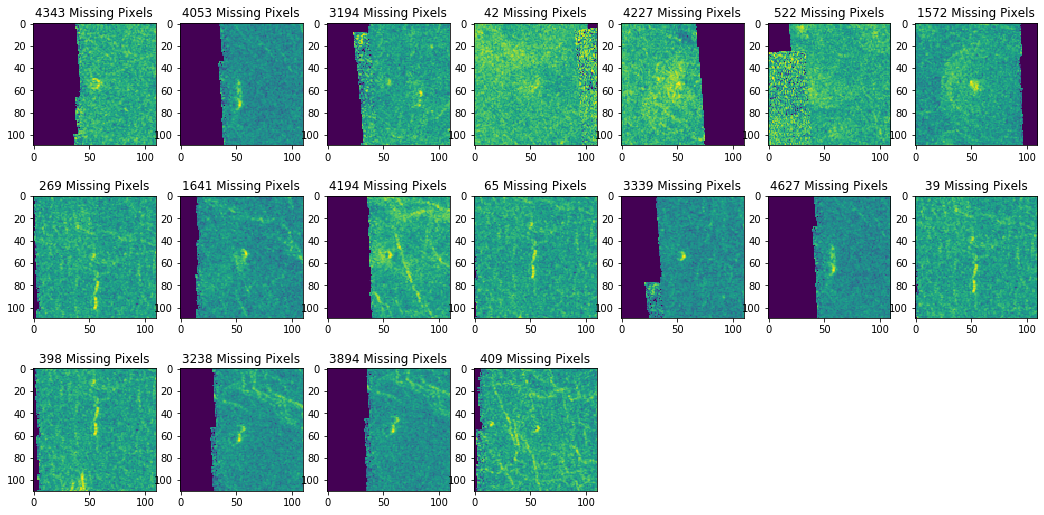

In [32]:
plt.figure(figsize = (18, 9))

j = 1
for i in vol_crpt_id[0:21]:
    subplot(3, 7, j)
    plt.imshow(np.array(dfs.loc[i]).reshape(110, 110))
    plt.title(str(df["DarkPxls"].loc[i]) + " Missing Pixels")
    j = j + 1

#### Imputing

As we already have a Class Imbalance (ver few images with Volcanoes) in the target variable on our original dataset, let's try not to remove the corrupted images that has volcanoes.

Instead let's fill the corrupted pixels in an image with the mean values of the corresponding image. 

But, should we use Row means or Column means?

It seems for most of the images the entire column is corrupted. So, let's use row means of image to replace the corrupted pixel.

In [0]:
vol_crpt_imgs = np.array(dfs.loc[vol_crpt_id]).reshape(22, 110, 110)

for i in range(vol_crpt_imgs.shape[0]):
    vol_crpt_imgs[i] = np.array(pd.DataFrame(vol_crpt_imgs[i]).T.replace(0, pd.DataFrame(vol_crpt_imgs[i]).mean(axis = 1).apply(int)).T)

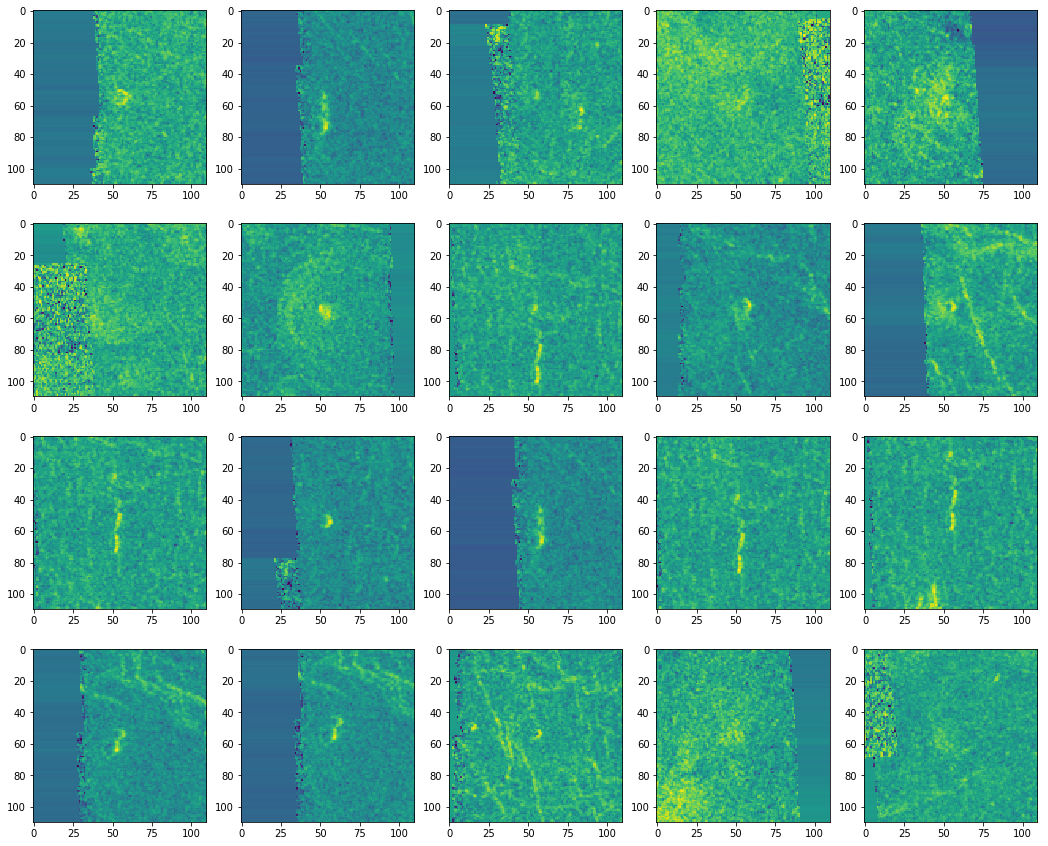

In [0]:
plt.figure(figsize = (18, 15))

for i in range(vol_crpt_imgs.shape[0]-2):
    subplot(4, 5, i+1)
    plt.imshow(vol_crpt_imgs[i])

The images doesn't look good. Row means doesn't seem like a great idea. 

Instead let's compute the mean of every pixel for all the images that are not corrupted and use those means to replace the corrupted pixels in corrupted images.

In [0]:
dfs = pd.concat([dfs, pd.DataFrame(dfs[df["DarkPxls"] == 0].mean().apply(int)).T], ignore_index = True)

In [0]:
dfs.loc[vol_crpt_id] = dfs.loc[vol_crpt_id].replace(0, dfs.loc[9734])

In [0]:
dfs.drop(index = 9734, inplace = True)

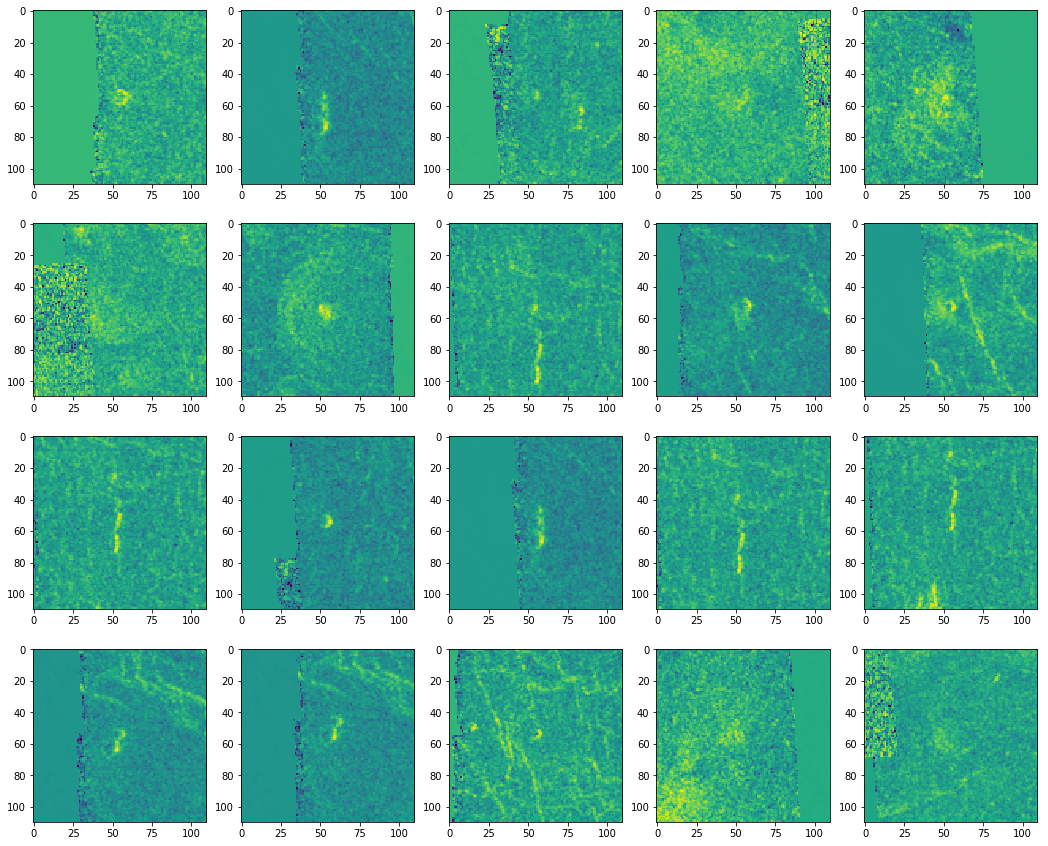

In [0]:
plt.figure(figsize = (18, 15))

j = 1
for i in vol_crpt_id[0:20]:
    subplot(4, 5, j)
    plt.imshow(np.array(dfs.loc[i]).reshape(110, 110))
    j = j + 1

Definitely not a wonderful improvement, but much better than using row means. Let's stick with these pixel values for corrupted images.

#### Corrupted Images without Volcanoes

In [0]:
novol_crpt_id = df.loc[crpt_id][df.loc[crpt_id]["Volcano"] == 0].index.values

df.loc[novol_crpt_id].head()

,0,1,2,3,4,5,6,7,8,9,...,12093,12094,12095,12096,12097,12098,12099,Volcano,trn_tst,DarkPxls
3,0,0,0,0,0,0,0,0,0,0,...,84,80,90,92,80,88,96,0,train,962
31,96,111,121,122,90,80,87,116,111,97,...,102,93,107,102,101,113,113,0,train,655
63,80,98,98,92,106,111,110,102,89,95,...,0,0,0,0,0,0,0,0,train,3566
116,0,0,0,0,0,0,0,0,0,0,...,105,101,102,99,104,101,112,0,train,4252
123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,train,12100


Let's plot a few records whose corrupted pixels are within 0.1 Quantile

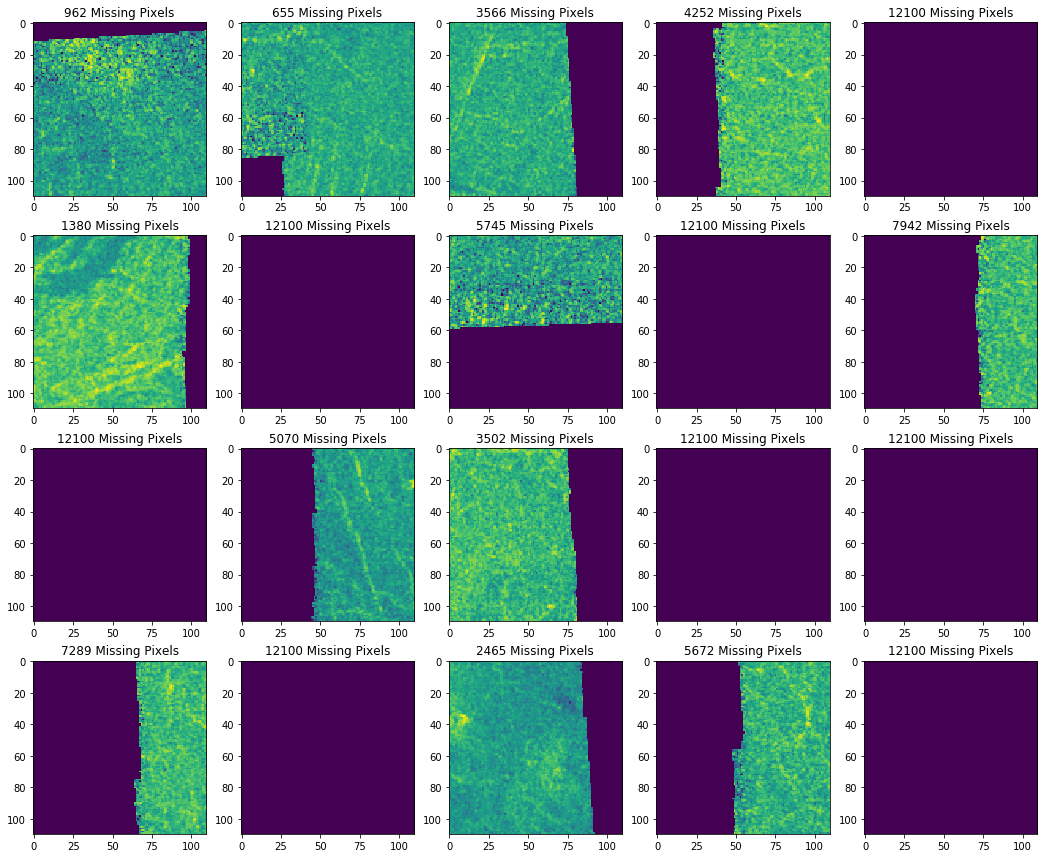

In [0]:
plt.figure(figsize = (18, 15))
j = 1
for i in novol_crpt_id[0:20]:
    subplot(4, 5, j)
    plt.imshow(np.array(dfs.loc[i]).reshape(110, 110))
    plt.title(str(df["DarkPxls"].loc[i]) + " Missing Pixels")
    j = j + 1

As our dataset already have a good number of examples without volcanoes, I think it would not be good idea to invest time to define threshold level for missing pixels or to impute data for corrupted pixels.

Let's omite the corrupted records.

### Omitting Corrupted Records with no Volcanoes

In [0]:
# dfs.drop(novol_crpt_id, inplace = True)

final_df = df[df["DarkPxls"] == 0].drop("DarkPxls", axis = 1)

In [45]:
final_df.shape

(6729, 12101)

In [0]:
# final_df = dfs.join(df.loc[dfs.index][["Volcano", "trn_tst"]])

In [0]:
final_df.to_csv("/content/drive/My Drive/VolcanoesOnVenus/venusvolcanoes.csv", index = False)

In [47]:
pd.read_csv("venusvolcanoes.csv")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano
0,95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,...,95,105,103,74,88,106,111,90,96,101,90,97,102,97,106,108,107,93,74,106,115,107,102,91,103,111,105,116,117,111,107,92,89,103,99,117,116,118,96,1
1,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,91,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81,0
2,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,80,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90,0
3,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,116,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115,0
4,79,95,90,82,73,74,77,75,82,87,84,81,83,69,72,84,93,84,89,83,86,89,95,94,82,80,96,96,89,86,93,88,82,70,76,84,82,59,81,101,...,78,73,91,94,90,81,80,70,71,73,84,87,89,97,99,92,77,87,96,75,78,92,72,83,86,95,87,78,90,90,80,79,78,65,71,62,97,89,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6724,90,96,88,95,94,100,95,80,80,71,86,83,94,79,97,95,90,80,100,114,120,104,111,112,95,91,95,95,92,99,108,96,88,92,103,99,89,101,97,86,...,95,84,90,91,79,79,89,90,90,95,82,68,79,89,87,94,90,92,86,93,80,53,66,77,94,86,74,87,89,88,83,72,76,73,79,76,79,84,69,0
6725,82,82,84,91,74,61,73,80,75,97,116,108,119,104,96,84,97,93,80,86,82,66,84,78,90,81,69,88,89,91,105,105,96,69,78,91,90,66,72,70,...,91,65,62,74,86,78,78,89,76,68,91,89,79,88,98,111,115,101,75,70,61,66,70,73,103,122,112,82,91,100,78,90,88,80,88,90,90,66,71,0
6726,133,102,121,133,129,131,98,121,123,125,119,110,125,137,123,97,122,135,140,139,132,114,121,123,127,136,133,133,142,133,117,132,110,82,99,113,116,112,119,109,...,111,130,136,113,115,106,110,129,136,131,133,143,118,130,134,139,134,119,123,136,145,136,132,126,127,123,109,123,125,120,123,119,111,104,102,119,130,131,111,0
6727,118,117,115,107,92,76,100,102,81,106,117,120,115,102,96,84,81,86,81,83,84,94,103,96,96,97,87,76,83,78,87,95,74,81,97,100,77,92,99,105,...,101,93,90,103,98,109,106,99,102,101,103,96,102,98,91,107,116,112,115,104,96,92,104,111,108,110,108,84,75,104,105,102,111,99,90,105,100,100,109,0
